In [1]:
library(DALEX)
library(auditor)

Welcome to DALEX (version: 0.2.5).


In [48]:
true_model <- function(model, data){
    return(200 + 150 * (abs(data$year_of_birth - 1000) > 500) + 0.05 * (data$height - 50)^2 + 70 * data$scars)
}

In [49]:
N <- 2000
set.seed(1313)

year_of_birth <- round(runif(N, -2000, 1800)) # year, for negative -n = n + 1 BC
year_of_discovery <- sort(round(runif(N, 1700, 1800))) # year
height <- rgamma(N, 50) # yards
weight <- 1/4 * height + rexp(N, 1) # tons
scars <- round(rexp(N, 0.1)) # number
colour <- sample(c('red', 'blue', 'green', 'black'), N, replace=TRUE, p=c(0.5, 0.3, 0.18, 0.02))
life_length <- true_model(NULL, data.frame(year_of_birth, height, weight, 
                                           scars, colour, year_of_discovery)) + rnorm(N, 0, 20)
df <- data.frame(year_of_birth, height, weight, scars, colour, year_of_discovery, life_length)

In [50]:
N <- 1000
set.seed(4242)

year_of_birth <- round(runif(N, -2000, 2000)) # year, for negative -n = n + 1 BC
year_of_discovery <- sort(round(runif(N, 1800, 2000))) # year
colour <- sample(c('red', 'blue', 'green', 'black'), N, replace=TRUE, p=c(0.4, 0.3, 0.1, 0.2))
height <- ifelse(
    colour == 'black' & year_of_discovery > 1840,
    rgamma(N, 200),
    rgamma(N, 50)
) # yards
weight <- 1/4 * height + rexp(N, 1) # tons
scars <- round(rexp(N, 0.1)) # number
life_length <- true_model(NULL, data.frame(year_of_birth, height, weight, 
                                           scars, colour, year_of_discovery)) + rnorm(N, 0, 20)
df_test <- data.frame(year_of_birth, height, weight, scars, colour, year_of_discovery, life_length)

In [51]:
head(df)
head(df_test)

year_of_birth,height,weight,scars,colour,year_of_discovery,life_length
1531,44.65054,12.82487,12,green,1700,1219.8319
-463,52.71104,18.56389,22,green,1700,1883.1912
837,47.40427,12.43831,1,red,1700,285.9589
-22,47.88570,13.39762,1,blue,1700,381.1834
553,46.19872,14.22780,4,blue,1700,490.2665
528,42.91617,12.15626,17,green,1700,1418.4039


year_of_birth,height,weight,scars,colour,year_of_discovery,life_length
1944,52.72899,14.53576,14,black,1800,1341.9766
-609,47.34525,12.12247,2,blue,1800,496.6474
-1080,44.88874,11.96229,21,blue,1800,1853.0963
675,47.82907,12.84190,18,blue,1800,1460.0822
811,53.49212,14.28875,1,blue,1801,272.5731
1738,41.37042,10.43020,20,blue,1801,1774.3387


# AUDITOR NA TRENINGU (BEZ DRYFU)

In [52]:
lm_model <- lm(life_length ~ ., data=df)

library("e1071")
svm_model <- svm(life_length ~ ., data=df)

library(randomForest)
rf_model  <- randomForest(life_length ~ ., data=df)

The beginning of each analysis is creation of a `modelAudit` object which contains metadata required for further analysis.

In [53]:
lm_audit <- audit(lm_model, label = "lm", data = df, y = df$life_length)
svm_audit <- audit(svm_model, label = "svm", data = df, y = df$life_length)
rf_audit <- audit(rf_model, label = "rf", data = df, y = df$life_length)

In [64]:
library(modelDown)
library(DALEX)

modexp <- explain(
    model = 1, 
    data = df, 
    y = df$life_length, 
    predict_function = true_model
)

modrf <- explain(
    model = rf_model, 
    data = df, 
    y = df$life_length
)

modlm <- explain(
    model = lm_model, 
    data = df, 
    y = df$life_length
)

modsvm <- explain(
    model = svm_model, 
    data = df, 
    y = df$life_length
)

modelDown::modelDown(modexp, modrf, modlm, modsvm)

[1] "Generating model_performance..."
[1] "Generating variable_importance..."
[1] "Generating variable_response..."


Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the c

[1] "Generating prediction_breakdown..."


## Model performance

The model performance can be checked on several scores. We can see on the plot below that both models perform similar with only small differences on each score.

In [58]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


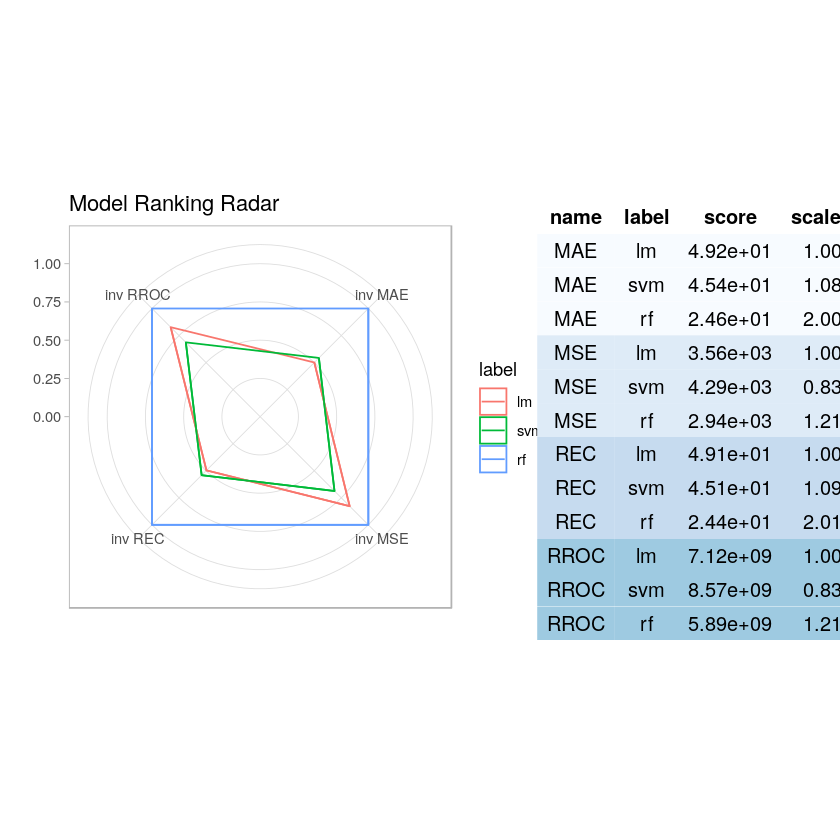

In [59]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

## Plotting residuals

Function `plot` used on `modelResiduals` object returns a Residuals vs some variable plot. Here we plot Residuals against ground truth.

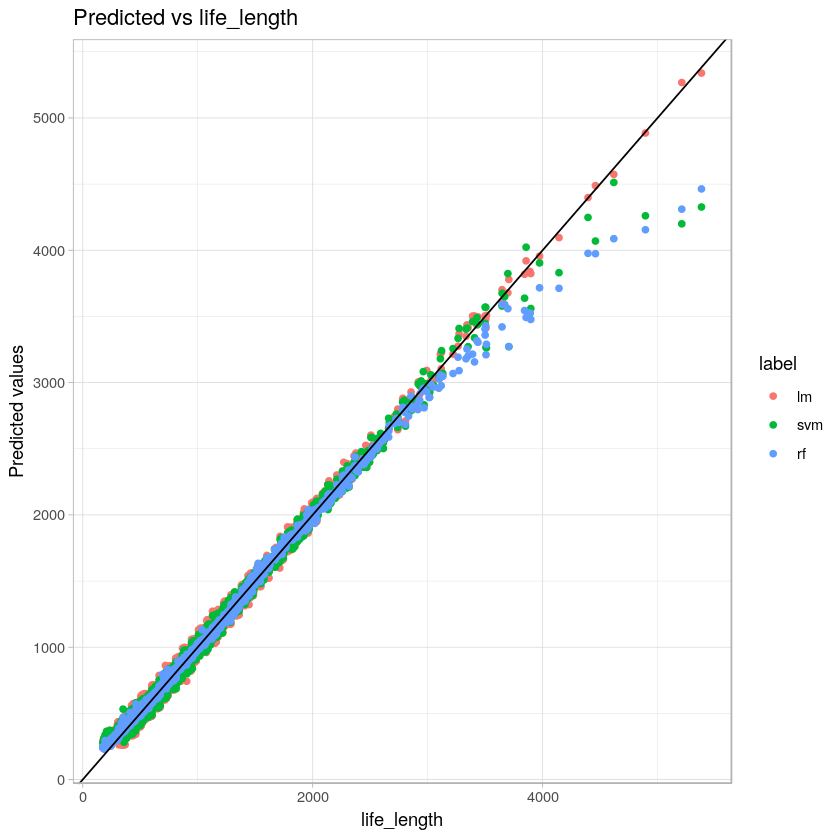

In [60]:
lm_mr_m2 <- modelResiduals(lm_audit, variable = "life_length")
svm_mr_m2 <- modelResiduals(svm_audit, variable = "life_length")
rf_mr_m2 <- modelResiduals(rf_audit, variable = "life_length")

plot(lm_mr_m2, svm_mr_m2, rf_mr_m2, type = "Prediction")

## Residual Density

Looks strange. The Residuals for linear model form two different groups. The `residualDensity` plot below shows it even better.

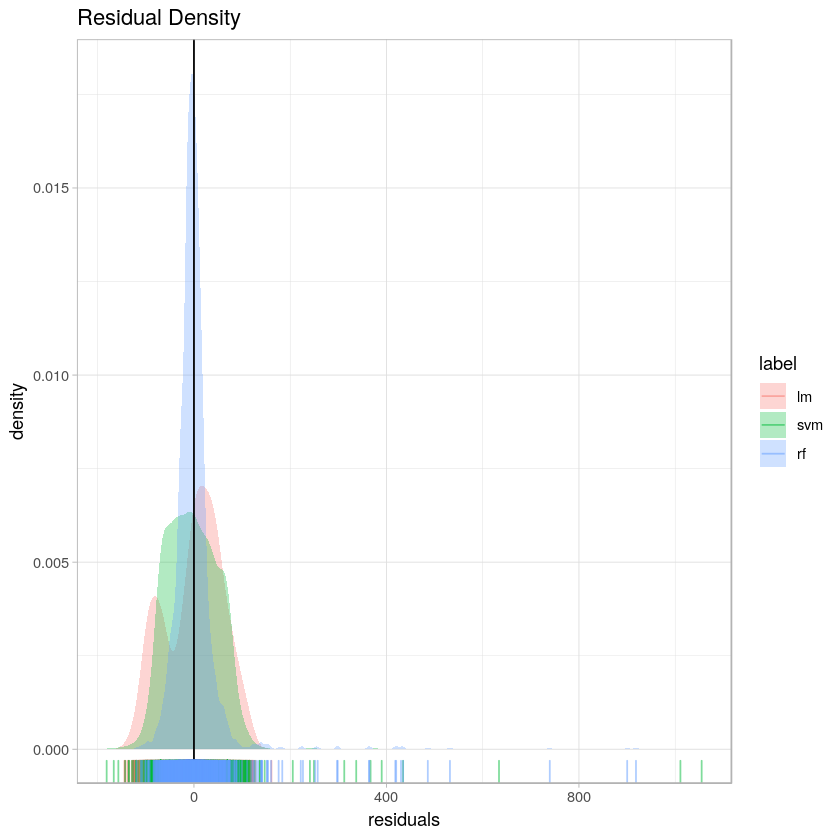

In [61]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

## Residuals vs variables

The above plot shows the bimodal distribution of the linear model residuals. Let's see if there is any correlation between dependent variables and residuals. Such behaviour could explain the bimodal distribution of the residuals and provide insight how to fix it.

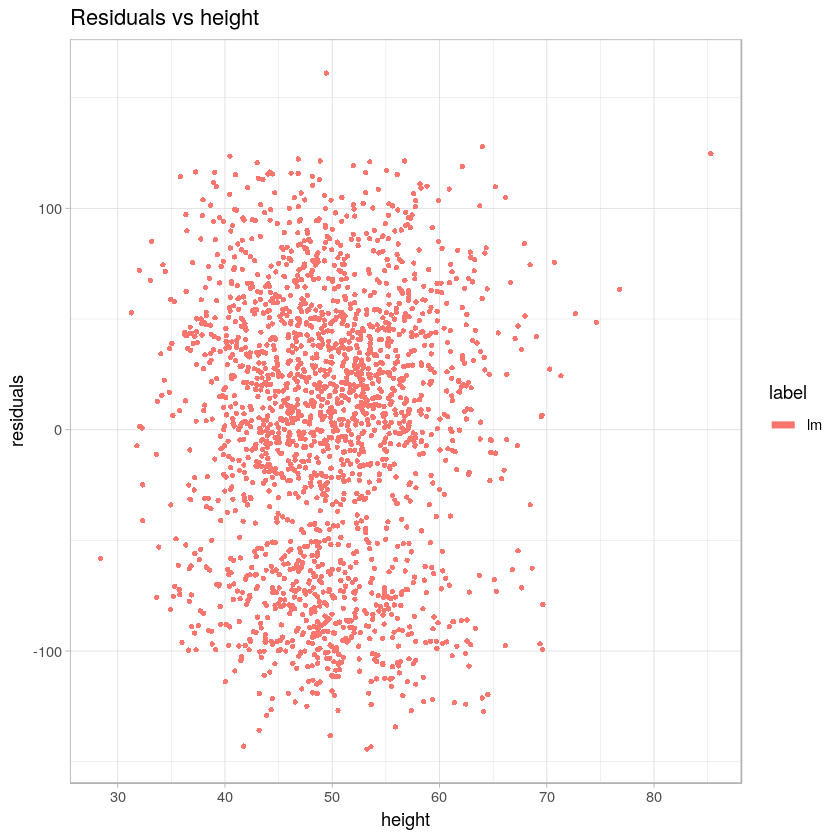

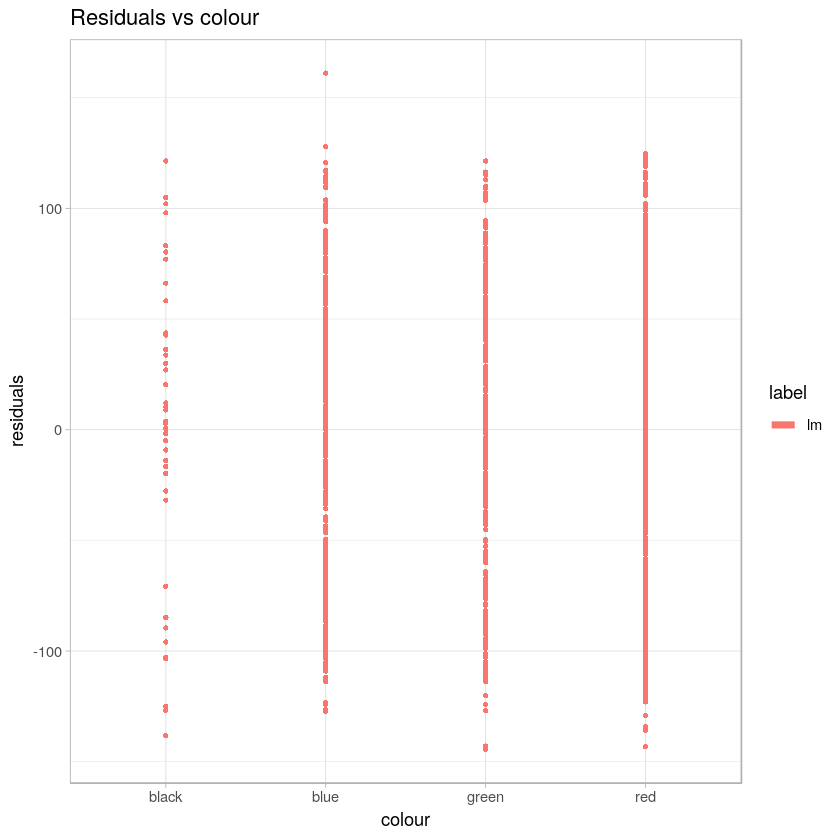

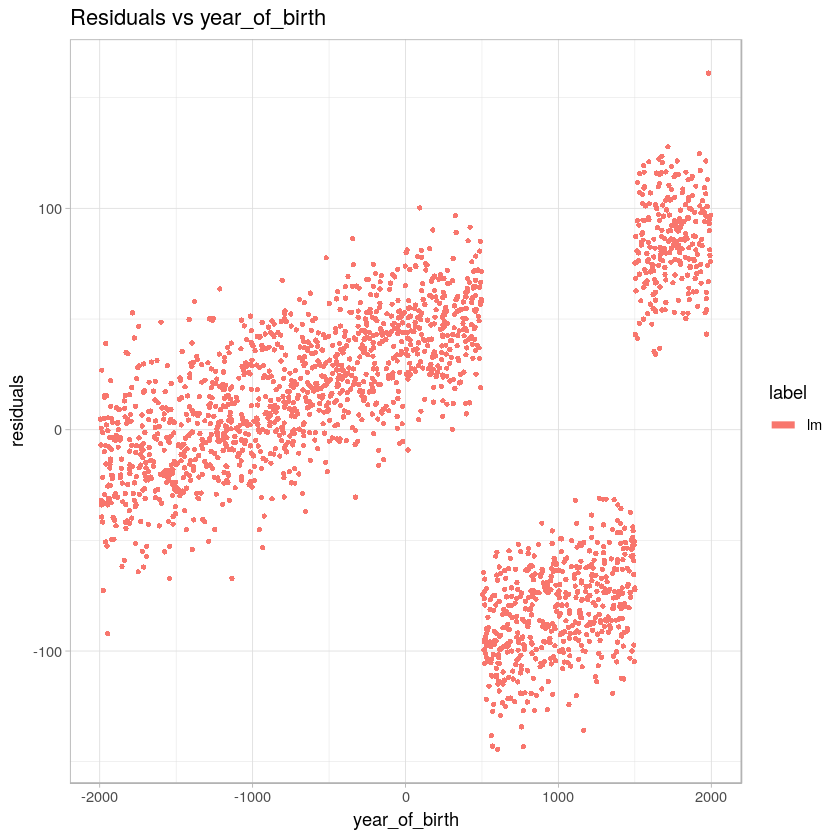

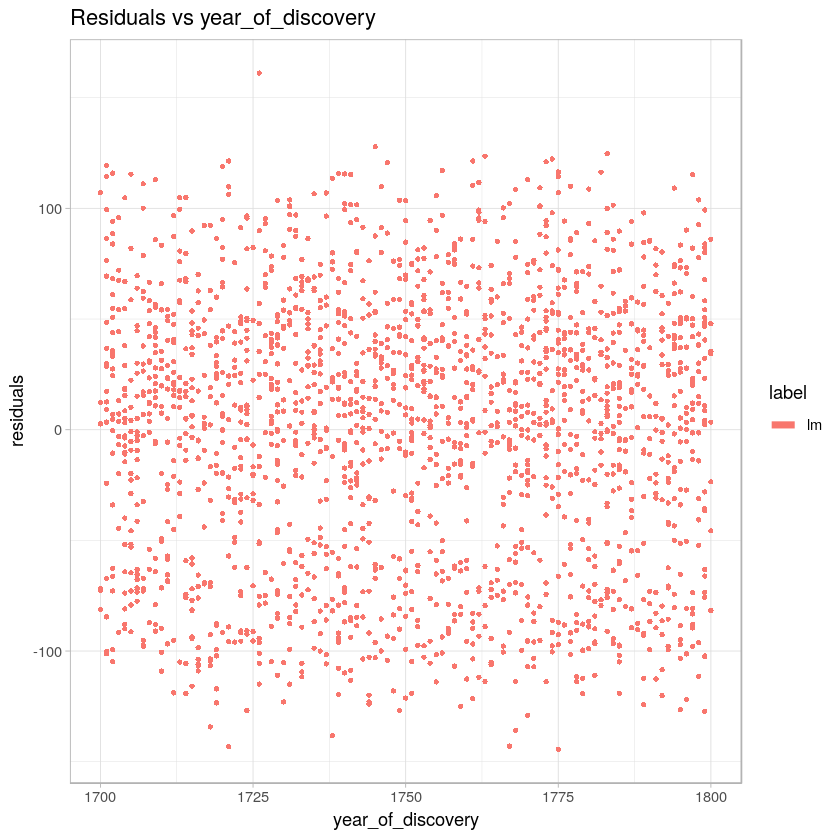

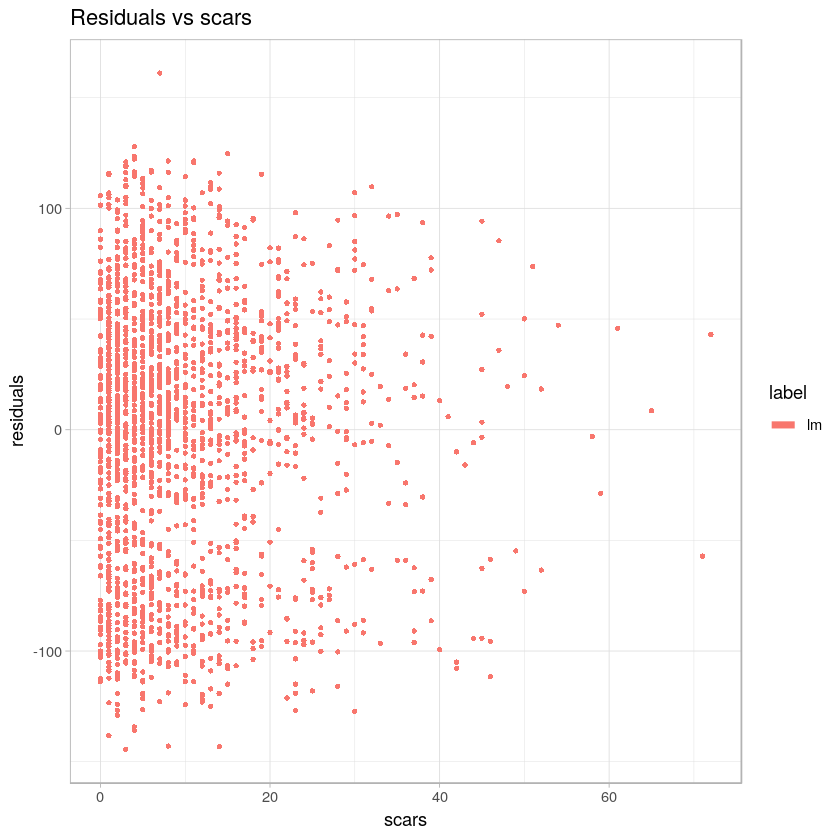

In [148]:
plotResidual(lm_audit, variable = 'height')
plotResidual(lm_audit, variable = 'colour')
plotResidual(lm_audit, variable = 'year_of_birth')
plotResidual(lm_audit, variable = 'year_of_discovery')
plotResidual(lm_audit, variable = 'scars')

We can see clearly, that the residuals change drastically with `teeth.len`. Let's try to replace `teeth.len` with a new variable `teeth.q` which indicates in which quartile the value is.

In [75]:
# quantiles <- c(quantile(dragons$teeth.len, probs = seq(0, 1, by = 0.25)))
# quantiles_test <- c(quantile(dragons_test$teeth.len, probs = seq(0, 1, by = 0.25)))

df$period <- cut(df$year_of_birth, c(-2000, 500, 1500, 1970, 2000), 
                 labels = c('ancient', 'middle_ages', 'early_modern', 'modern'), include.lowest = TRUE)
df_test$period <- cut(df_test$year_of_birth, c(-2000, 500, 1500, 1970, 2000), 
                 labels = c('ancient', 'middle_ages', 'early_modern', 'modern'), include.lowest = TRUE)


head(df)
head(df_test)
# df$teeth.q <- cut(dragons_test$teeth.len, quantiles_test, 
#                             labels = c(0, 1, 2, 3), include.lowest = TRUE)

year_of_birth,height,weight,scars,colour,year_of_discovery,life_length,period
1531,44.65054,12.82487,12,green,1700,1219.8319,early_modern
-463,52.71104,18.56389,22,green,1700,1883.1912,ancient
837,47.40427,12.43831,1,red,1700,285.9589,middle_ages
-22,47.88570,13.39762,1,blue,1700,381.1834,ancient
553,46.19872,14.22780,4,blue,1700,490.2665,middle_ages
528,42.91617,12.15626,17,green,1700,1418.4039,middle_ages


year_of_birth,height,weight,scars,colour,year_of_discovery,life_length,period
1944,52.72899,14.53576,14,black,1800,1341.9766,early_modern
-609,47.34525,12.12247,2,blue,1800,496.6474,ancient
-1080,44.88874,11.96229,21,blue,1800,1853.0963,ancient
675,47.82907,12.84190,18,blue,1800,1460.0822,middle_ages
811,53.49212,14.28875,1,blue,1801,272.5731,middle_ages
1738,41.37042,10.43020,20,blue,1801,1774.3387,early_modern


## New models

Now, we can fit new models on that variable.

In [65]:
lm_model <- lm(life_length ~ ., data=df)
svm_model <- svm(life_length ~ ., data=df)
rf_model <- randomForest(life_length ~ ., data=df)

In [152]:
# modelDown(explain(svm_model, data=df, y=df$life_length), 
#           explain(lm_model, data=df, y=df$life_length))
#           explain(NULL, predict_function=true_model, data=df, y=df$life_length))

In [66]:
lm_audit <- audit(lm_model, label = "lm", data = df, y = df$life_length)
svm_audit <- audit(svm_model, label = "svm", data = df, y = df$life_length)
rf_audit <- audit(rf_model, label = "rf", data = df, y = df$life_length)

In [67]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

First, let's see how the residual density looks like.

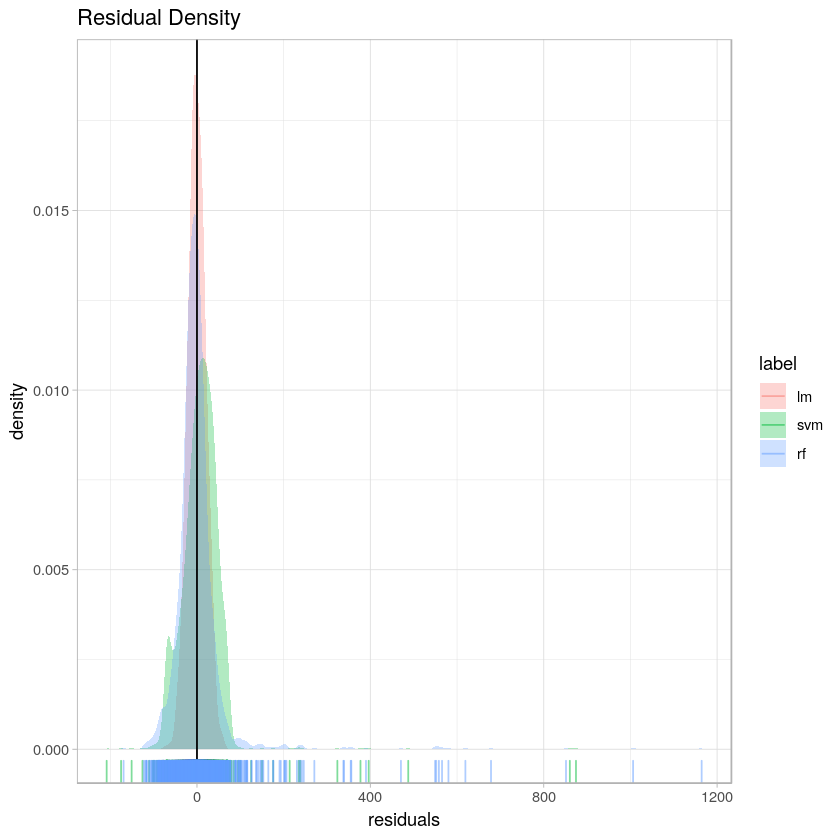

In [69]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

Much better. Now the residuals against `teeth.len`. No correlation can be seen now.

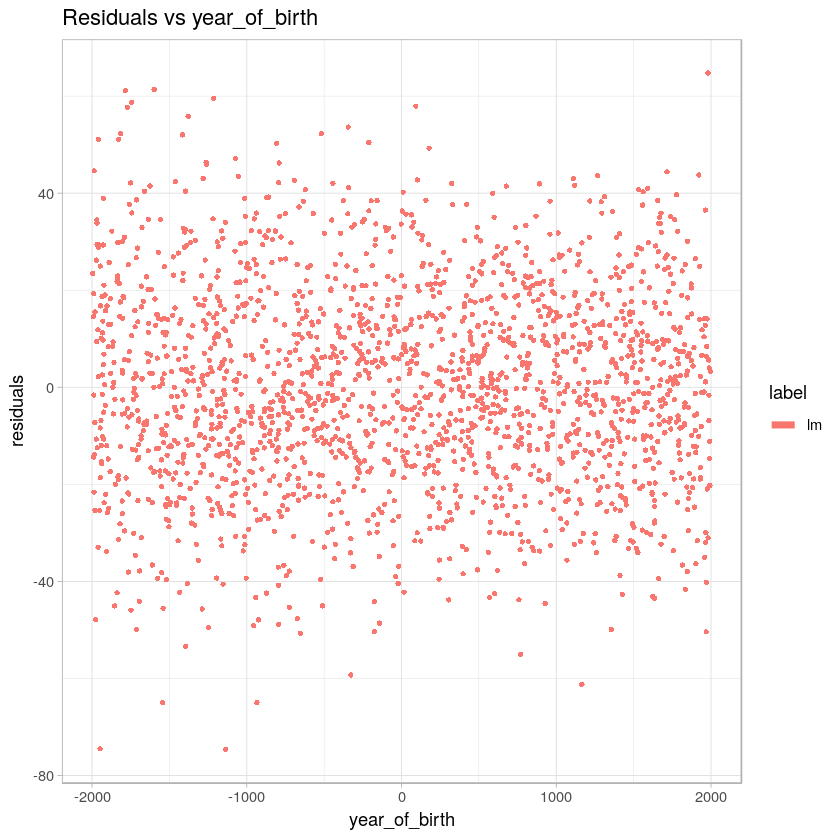

In [70]:
plotResidual(lm_audit, variable = 'year_of_birth')

Let's check the performance of the models.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


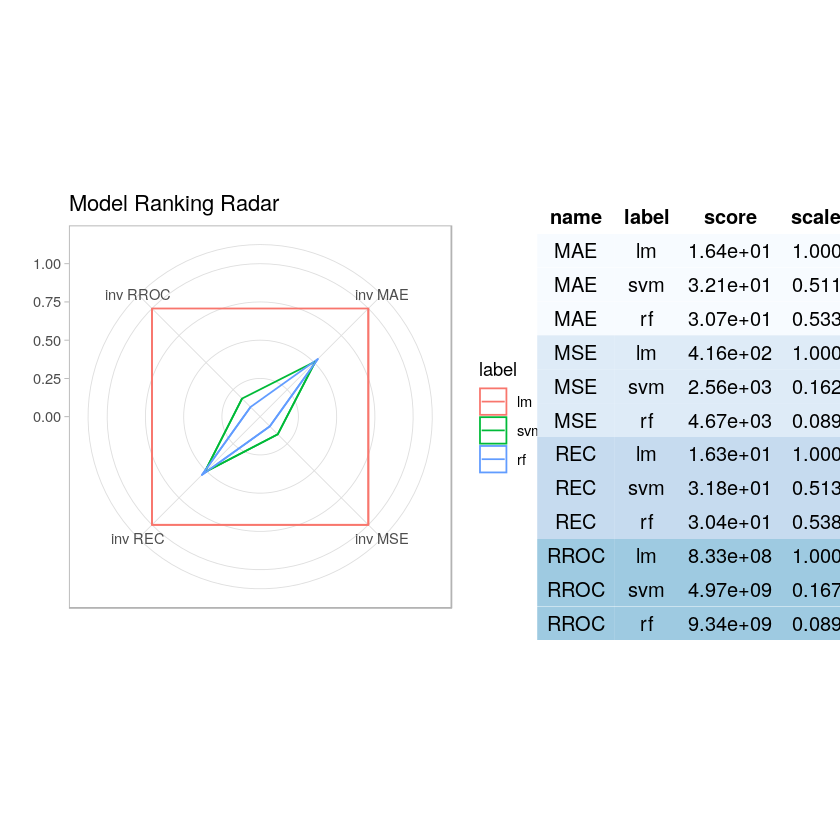

In [71]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

Now the linear model is much better than it was before changing the variable. We were able to tweak the performance of the model by closely looking at residuals.

# AUDITOR NA TEŚCIE (Z DRYFEM)

In [87]:
lm_model <- lm(life_length ~ ., data=df)

library("e1071")
svm_model <- svm(life_length ~ ., data=df)
rf_model <- randomForest(life_length ~ ., data=df)

In [88]:
lm_audit <- audit(lm_model, label = "lm", data = df_test, y = df_test$life_length)
svm_audit <- audit(svm_model, label = "svm", data = df_test, y = df_test$life_length)
rf_audit <- audit(rf_model, label = "rf", data = df_test, y = df_test$life_length)

In [ ]:
modexp <- explain(
    model = 1, 
    data = df_test, 
    y = df_test$life_length, 
    predict_function = true_model
)

modrf <- explain(
    model = rf_model, 
    data = df_test, 
    y = df_test$life_length
)

modlm <- explain(
    model = lm_model, 
    data = df_test, 
    y = df_test$life_length
)

modsvm <- explain(
    model = svm_model, 
    data = df_test, 
    y = df_test$life_length
)

modelDown::modelDown(modexp, modrf, modlm, modsvm)

## Model performance

The model performance can be checked on several scores. We can see on the plot below that both models perform similar with only small differences on each score.

In [77]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


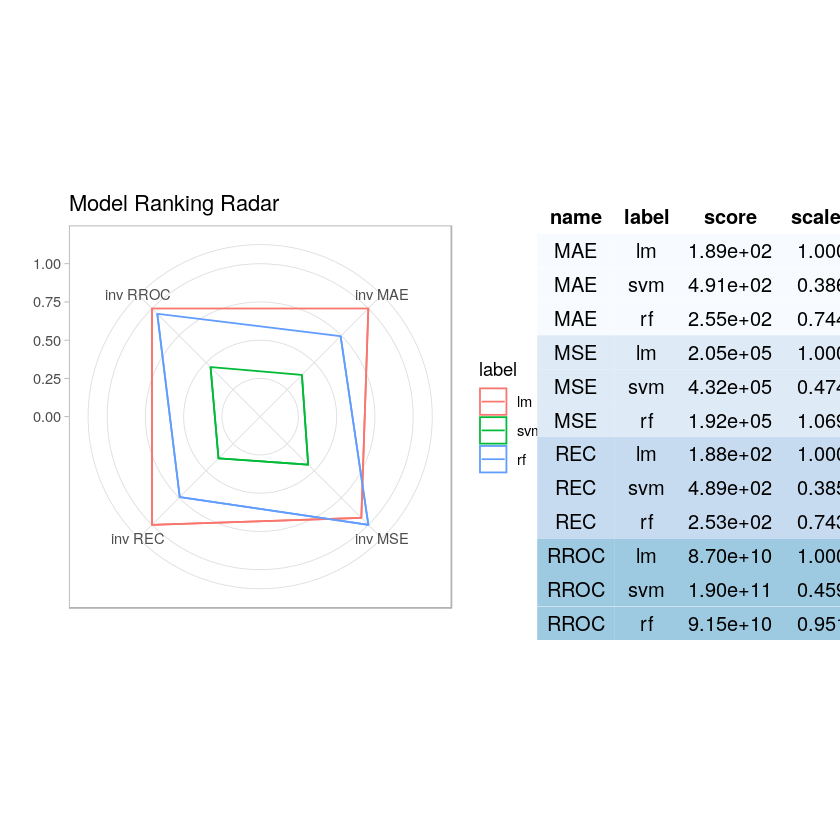

In [78]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

## Plotting residuals

Function `plot` used on `modelResiduals` object returns a Residuals vs some variable plot. Here we plot Residuals against ground truth.

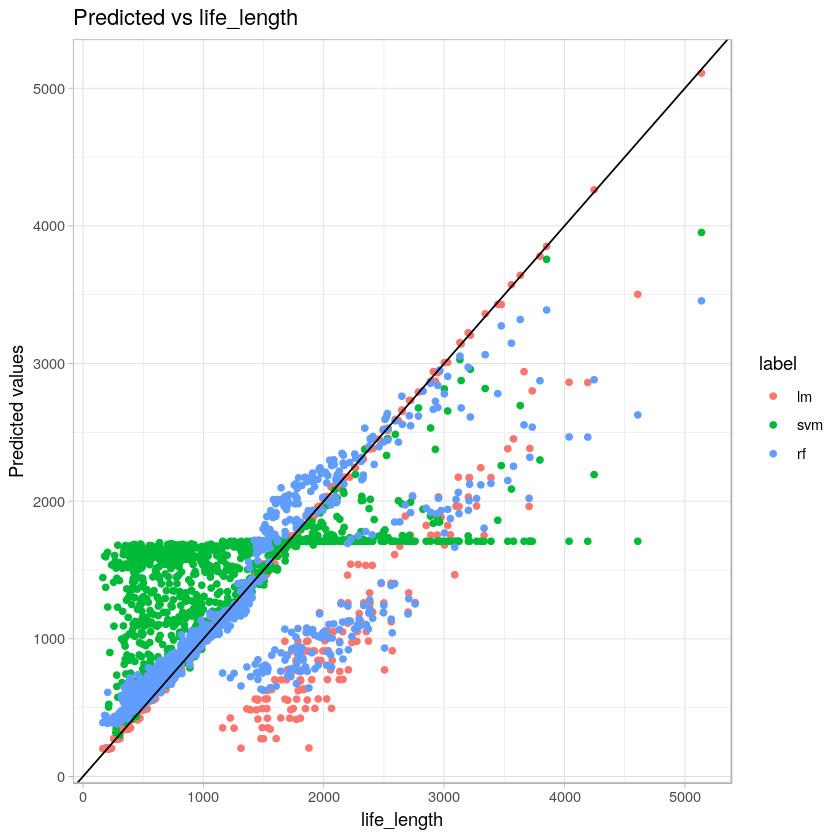

In [79]:
lm_mr_m2 <- modelResiduals(lm_audit, variable = "life_length")
svm_mr_m2 <- modelResiduals(svm_audit, variable = "life_length")
rf_mr_m2 <- modelResiduals(rf_audit, variable = "life_length")


plot(lm_mr_m2, svm_mr_m2, rf_mr_m2, type = "Prediction")

## Residual Density

Looks strange. The Residuals for linear model form two different groups. The `residualDensity` plot below shows it even better.

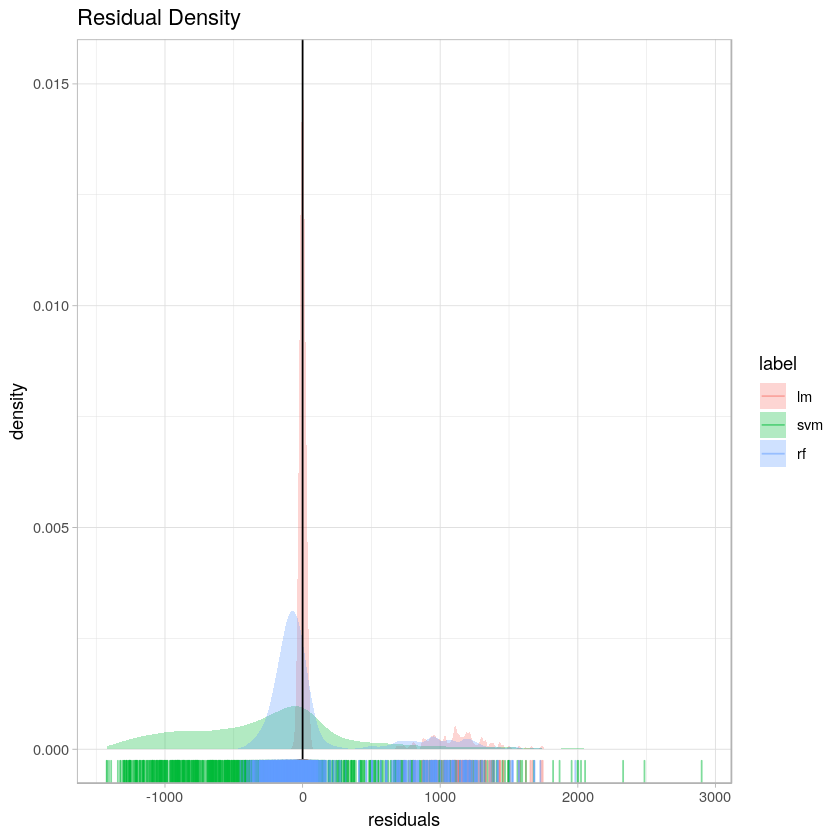

In [80]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

## Residuals vs variables

The above plot shows the bimodal distribution of the linear model residuals. Let's see if there is any correlation between dependent variables and residuals. Such behaviour could explain the bimodal distribution of the residuals and provide insight how to fix it.

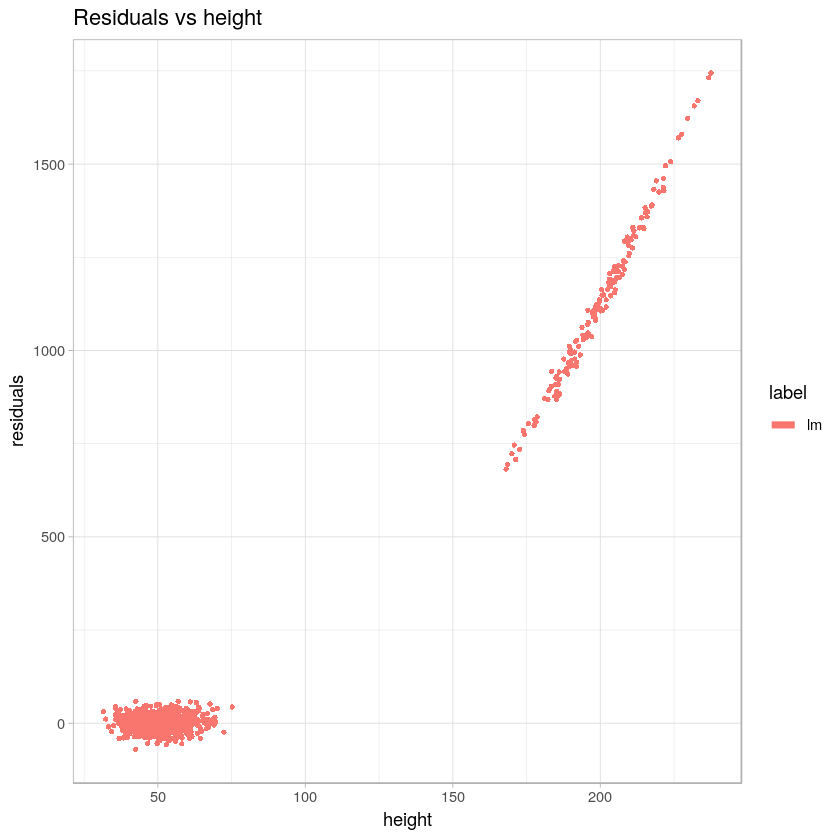

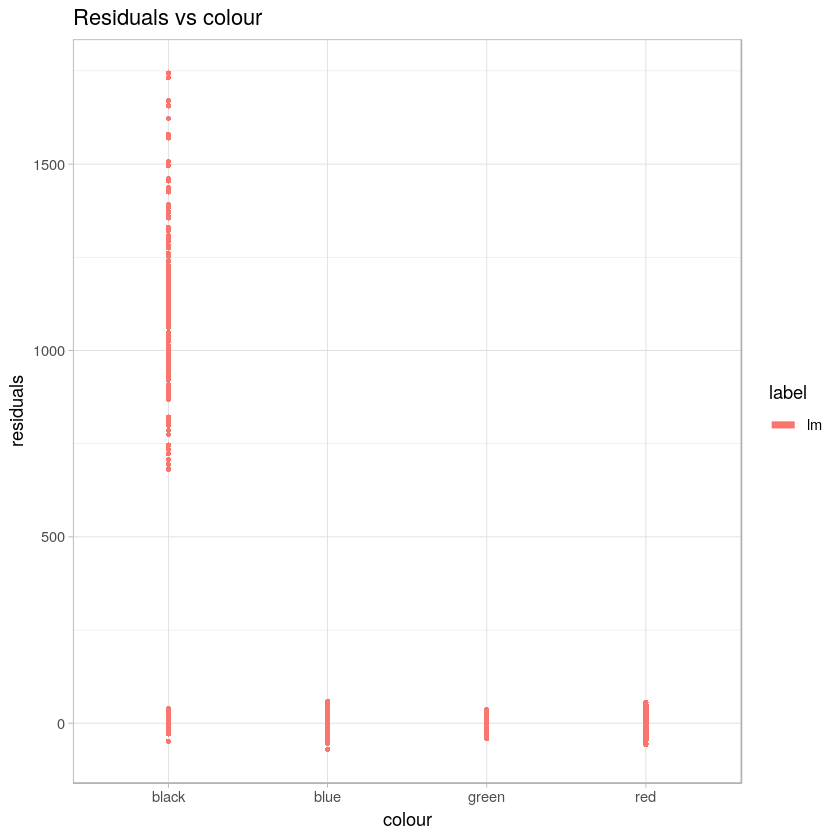

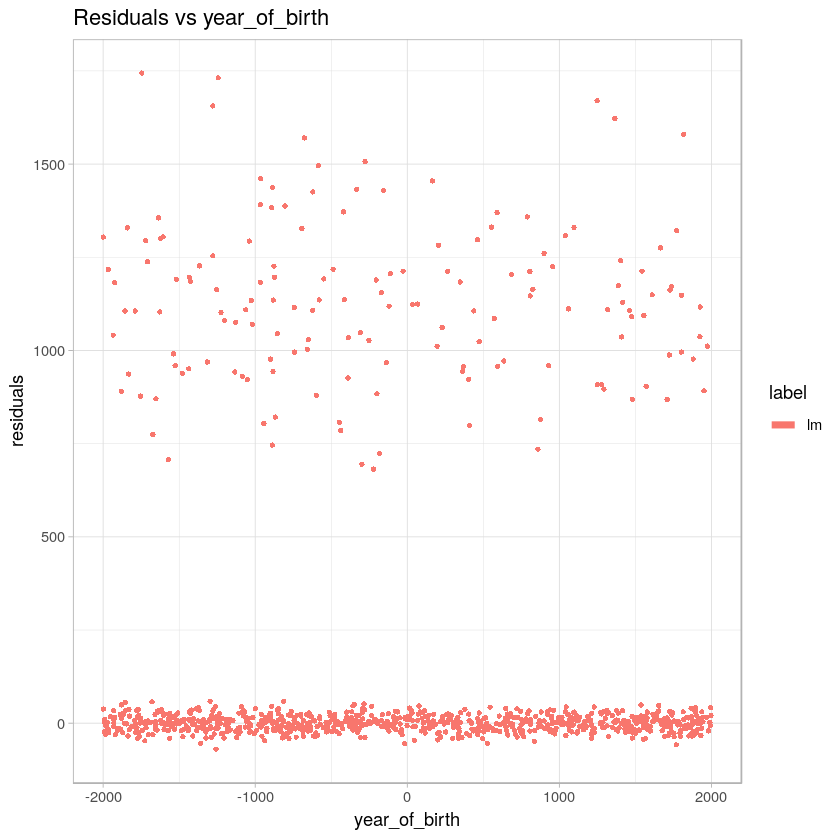

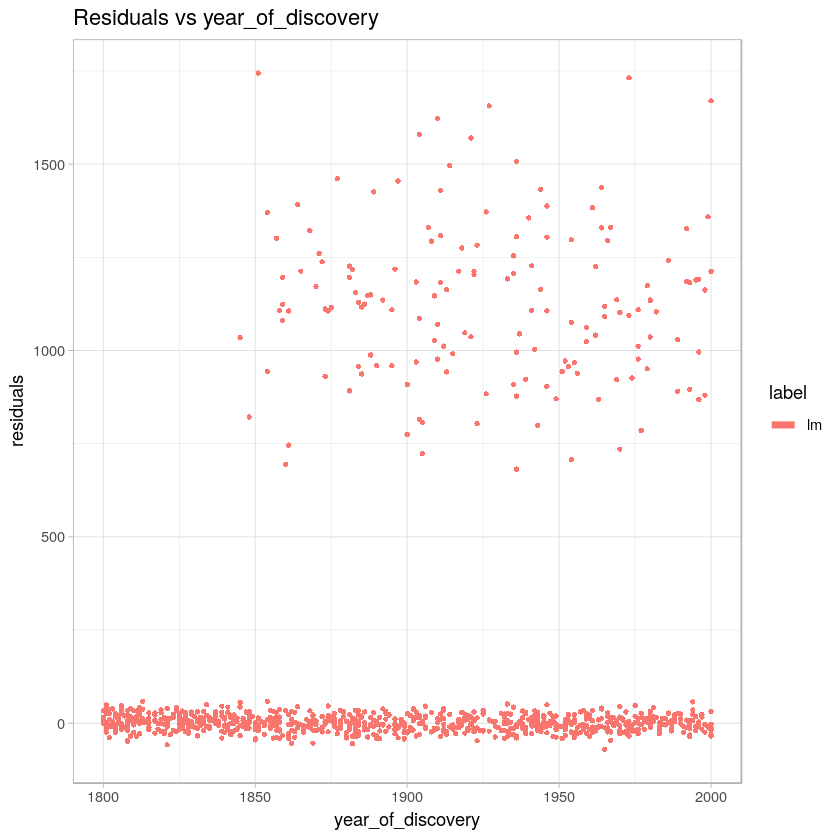

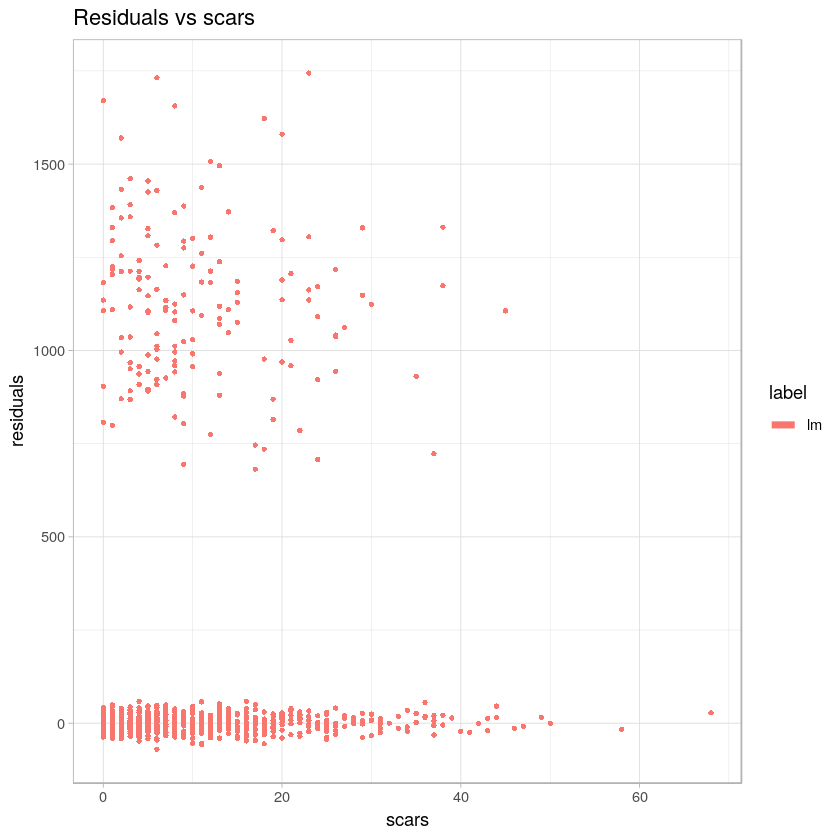

In [81]:
plotResidual(lm_audit, variable = 'height')
plotResidual(lm_audit, variable = 'colour')
plotResidual(lm_audit, variable = 'year_of_birth')
plotResidual(lm_audit, variable = 'year_of_discovery')
plotResidual(lm_audit, variable = 'scars')

We can see clearly, that the residuals change drastically with `teeth.len`. Let's try to replace `teeth.len` with a new variable `teeth.q` which indicates in which quartile the value is.

In [83]:
# quantiles <- c(quantile(dragons$teeth.len, probs = seq(0, 1, by = 0.25)))
# quantiles_test <- c(quantile(dragons_test$teeth.len, probs = seq(0, 1, by = 0.25)))

df$height_squared <- df$height^2
df_test$height_squared <- df_test$height^2
# head(df)
# df$teeth.q <- cut(dragons_test$teeth.len, quantiles_test, 
#                             labels = c(0, 1, 2, 3), include.lowest = TRUE)

## New models

Now, we can fit new models on that variable.

In [89]:
lm_model <- lm(life_length ~ ., data=df)
svm_model <- svm(life_length ~ ., data=df)
rf_model <- randomForest(life_length ~ ., data=df)

In [90]:
modexp <- explain(
    model = 1, 
    data = df_test, 
    y = df_test$life_length, 
    predict_function = true_model
)

modrf <- explain(
    model = rf_model, 
    data = df_test, 
    y = df_test$life_length
)

modlm <- explain(
    model = lm_model, 
    data = df_test, 
    y = df_test$life_length
)

modsvm <- explain(
    model = svm_model, 
    data = df_test, 
    y = df_test$life_length
)

modelDown::modelDown(modexp, modrf, modlm, modsvm)

[1] "Generating model_performance..."
[1] "Generating variable_importance..."
[1] "Generating variable_response..."


Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Variable colour  is of the class factor. Type of explainer changed to 'factor'.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the class factor. Type of explainer changed to 'factor'.
Variable period  is of the c

[1] "Generating prediction_breakdown..."


In [91]:
lm_audit <- audit(lm_model, label = "lm", data = df_test, y = df_test$life_length)
svm_audit <- audit(svm_model, label = "svm", data = df_test, y = df_test$life_length)
rf_audit <- audit(rf_model, label = "rf", data = df_test, y = df_test$life_length)

In [92]:
lm_mp <- modelPerformance(lm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
svm_mp <- modelPerformance(svm_audit, scores = c("MAE", "MSE", "REC", "RROC"))
rf_mp <- modelPerformance(rf_audit, scores = c("MAE", "MSE", "REC", "RROC"))

First, let's see how the residual density looks like.

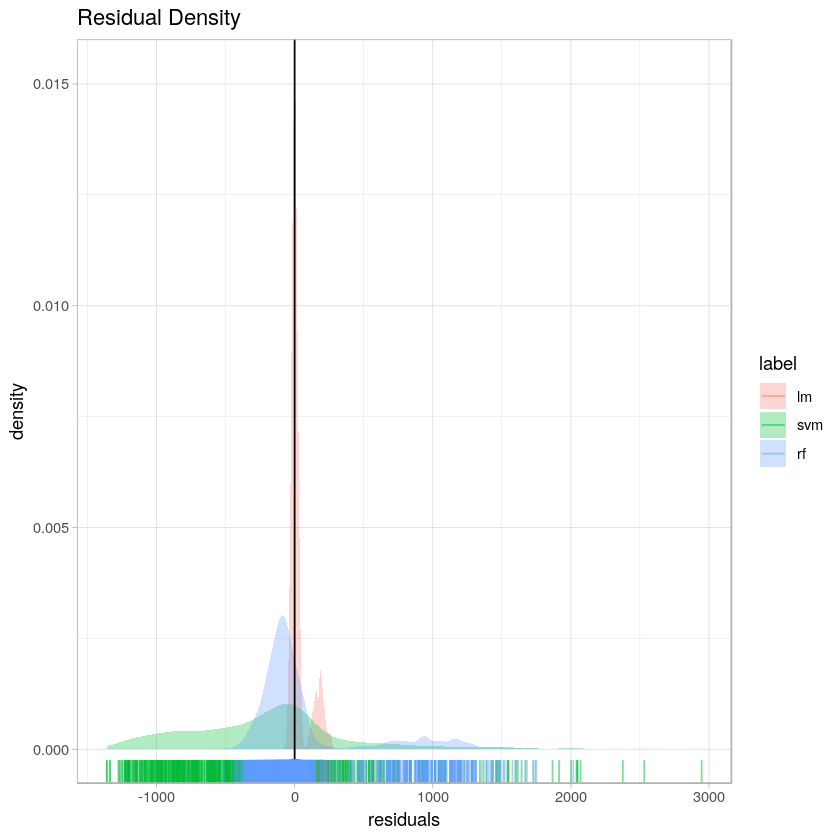

In [93]:
plotResidualDensity(lm_audit, svm_audit, rf_audit)

Much better. Now the residuals against `teeth.len`. No correlation can be seen now.

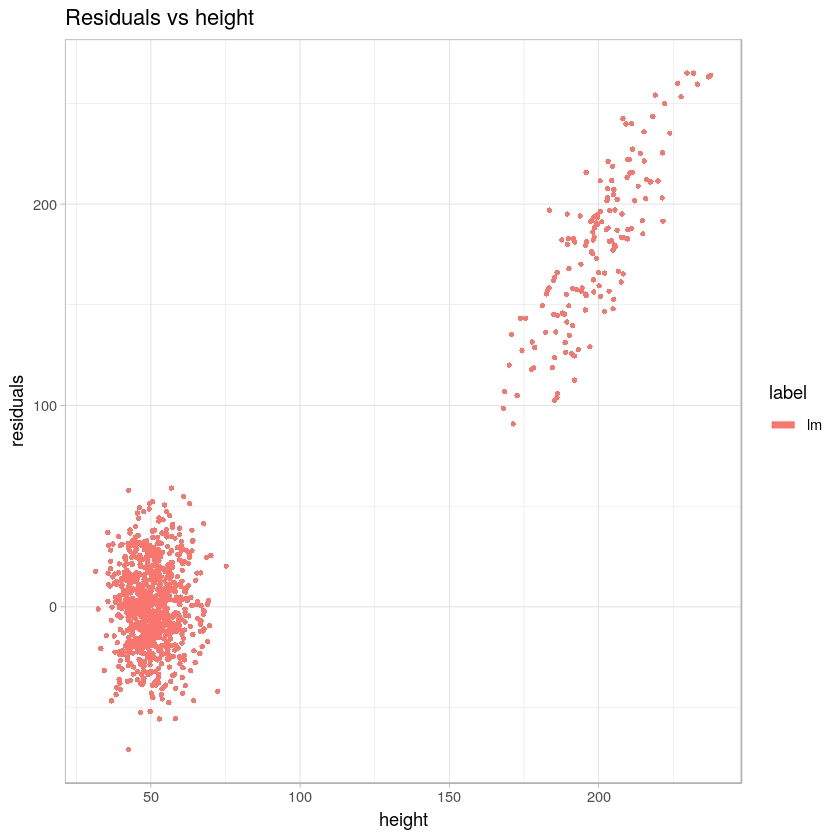

In [96]:
plotResidual(lm_audit, variable = 'height')

Let's check the performance of the models.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


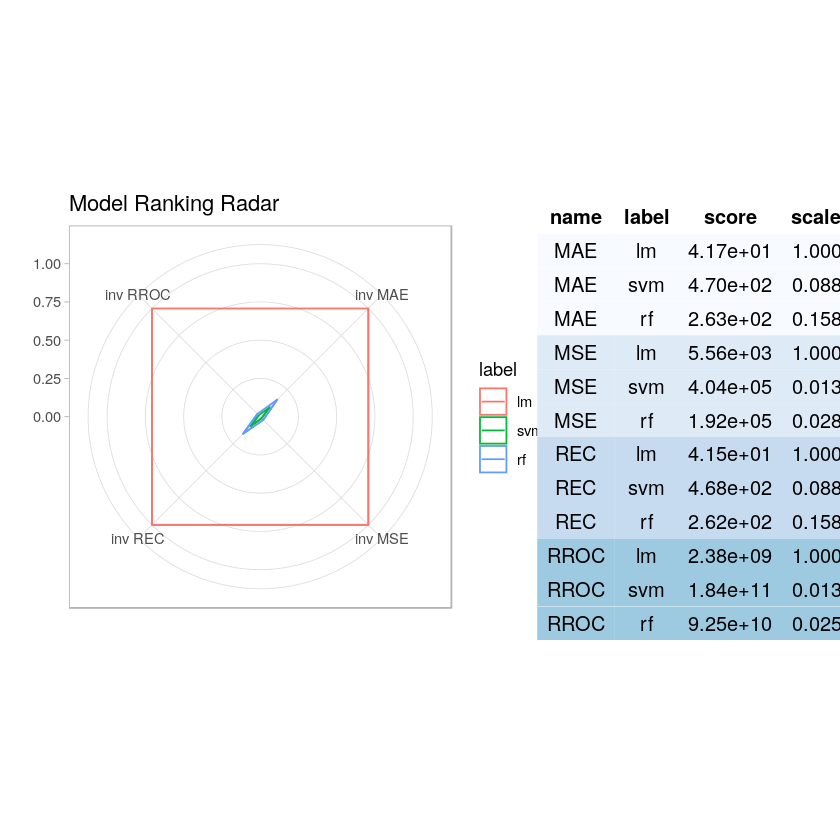

In [97]:
plot(lm_mp, svm_mp, rf_mp, table = TRUE)

Now the linear model is much better than it was before changing the variable. We were able to tweak the performance of the model by closely looking at residuals.